In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [486]:
df = pd.read_csv(r'/kaggle/input/data-weather/3.csv', delimiter=',')
df['Unnamed: 0'] = df['Unnamed: 0'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
measure_param = ['pressure', 'temperature', 'humidity']
for param in measure_param:
    # Группировка данных по месяцам и расчет средних значений для каждого месяца
    monthly_means = df.groupby(df['Unnamed: 0'].dt.to_period('M'))[f'{param}'].mean()
    # Замена пропущенных значений средними значениями для соответствующих месяцев
    threshold = monthly_means * 0.8
    for index, row in df.iterrows():
        if pd.isna(row[param]) or row[param] == 0:
            month_mean = monthly_means[row['Unnamed: 0'].to_period('M')]
            df.at[index, param] = month_mean
        elif row[param] < threshold[row['Unnamed: 0'].to_period('M')]:
            month_mean = monthly_means[row['Unnamed: 0'].to_period('M')]
            df.at[index, param] = month_mean


In [487]:
df

,Unnamed: 0,lat,lon,pressure,temperature,humidity
0,2023-01-01,55.738886,37.626723,73752.854813,3.131437,64.745972
1,2023-01-02,55.738886,37.626723,74446.836980,0.929654,52.735234
2,2023-01-03,55.738886,37.626723,73807.089999,1.046090,59.451535
3,2023-01-04,55.738886,37.626723,74160.503644,-1.190577,56.537941
4,2023-01-05,55.738886,37.626723,73913.078029,-2.617934,53.796811
...,...,...,...,...,...,...
461,2024-04-22,55.748919,37.584706,70743.468118,10.145756,51.552433
462,2024-04-23,55.748919,37.584706,71223.740219,8.409717,46.104545
463,2024-04-24,55.748919,37.584706,71173.460260,10.069335,53.334535
464,2024-04-25,55.748919,37.584706,70495.552868,13.158485,48.302183


In [488]:
min_max_mean = {}
for param in measure_param:
    min_max_mean[param] = [round(df[param][-7:].min(), 1), round(df[param][-7:].max(), 1), round(df[param][-7:].mean(), 1)]
min_max_mean

{'pressure': [70495.6, 71223.7, 70906.7],
 'temperature': [8.4, 14.7, 11.0],
 'humidity': [44.8, 53.3, 48.8]}

In [490]:
# 'pressure', 'temperature', 'humidity'
param = 'pressure'
my_dict = {key: [val] for key, val in zip(df['Unnamed: 0'].tolist(), df[param])}

new_df = pd.DataFrame({'meas': [param]})

new_df = pd.concat([new_df, pd.DataFrame(my_dict)], axis=1)
new_df

,meas,2023-01-01 00:00:00,2023-01-02 00:00:00,2023-01-03 00:00:00,2023-01-04 00:00:00,2023-01-05 00:00:00,2023-01-06 00:00:00,2023-01-07 00:00:00,2023-01-08 00:00:00,2023-01-09 00:00:00,...,2024-04-17 00:00:00,2024-04-18 00:00:00,2024-04-19 00:00:00,2024-04-20 00:00:00,2024-04-21 00:00:00,2024-04-22 00:00:00,2024-04-23 00:00:00,2024-04-24 00:00:00,2024-04-25 00:00:00,2024-04-26 00:00:00
0,pressure,73752.854813,74446.83698,73807.089999,74160.503644,73913.078029,74826.467772,75535.028634,75724.953057,76020.719692,...,69825.210422,70201.100735,69631.663905,71092.039716,71071.42356,70743.468118,71223.740219,71173.46026,70495.552868,70546.910538


In [491]:
new_df.shape

(1, 467)

In [492]:
values = new_df[new_df['meas'] == param].iloc[0, 1:].values
df1 = pd.DataFrame(values)
df1

,0
0,73752.854813
1,74446.83698
2,73807.089999
3,74160.503644
4,73913.078029
...,...
461,70743.468118
462,71223.740219
463,71173.46026
464,70495.552868


In [493]:
df1.rename(columns={df1.columns[0]:param}, inplace=True)

<Axes: >

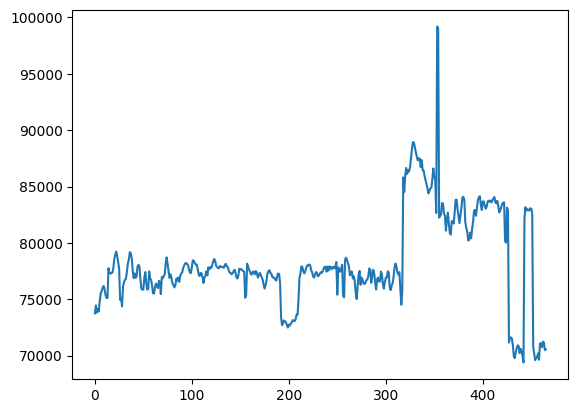

In [494]:
df1.iloc[:,0][: ].plot()

In [495]:
df1['date'] = new_df.columns[1:]
df1['date'] = df1['date'].apply(lambda x: x.strftime("%Y-%m-%d"))
df1 = df1.set_index('date')
 

In [496]:
 
df1.head()


,pressure
date,
2023-01-01,73752.854813
2023-01-02,74446.83698
2023-01-03,73807.089999
2023-01-04,74160.503644
2023-01-05,73913.078029


<Axes: xlabel='date'>

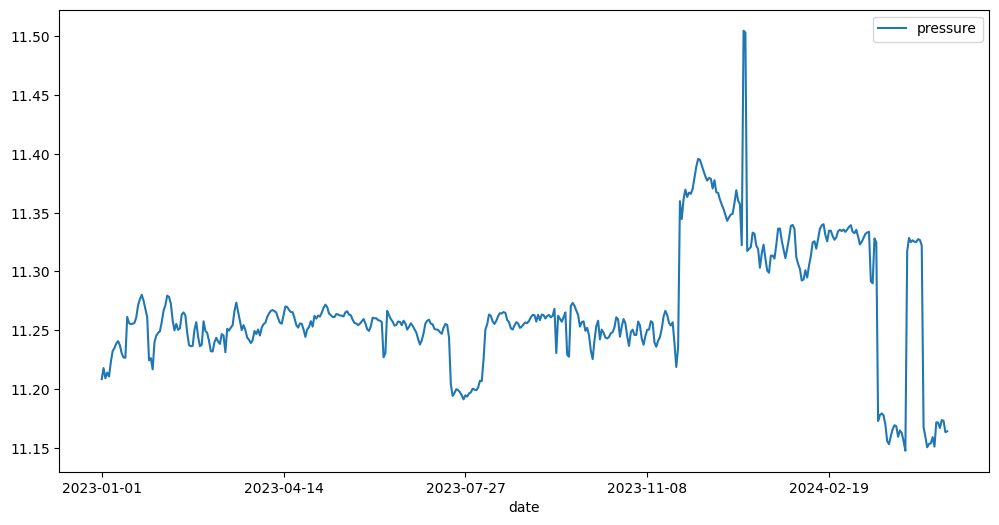

In [497]:
df1[param] = pd.to_numeric(df1[param], errors='coerce')
log_pressure = np.log(df1)
log_pressure.plot(figsize=(12,6))

In [ ]:
df1.info()

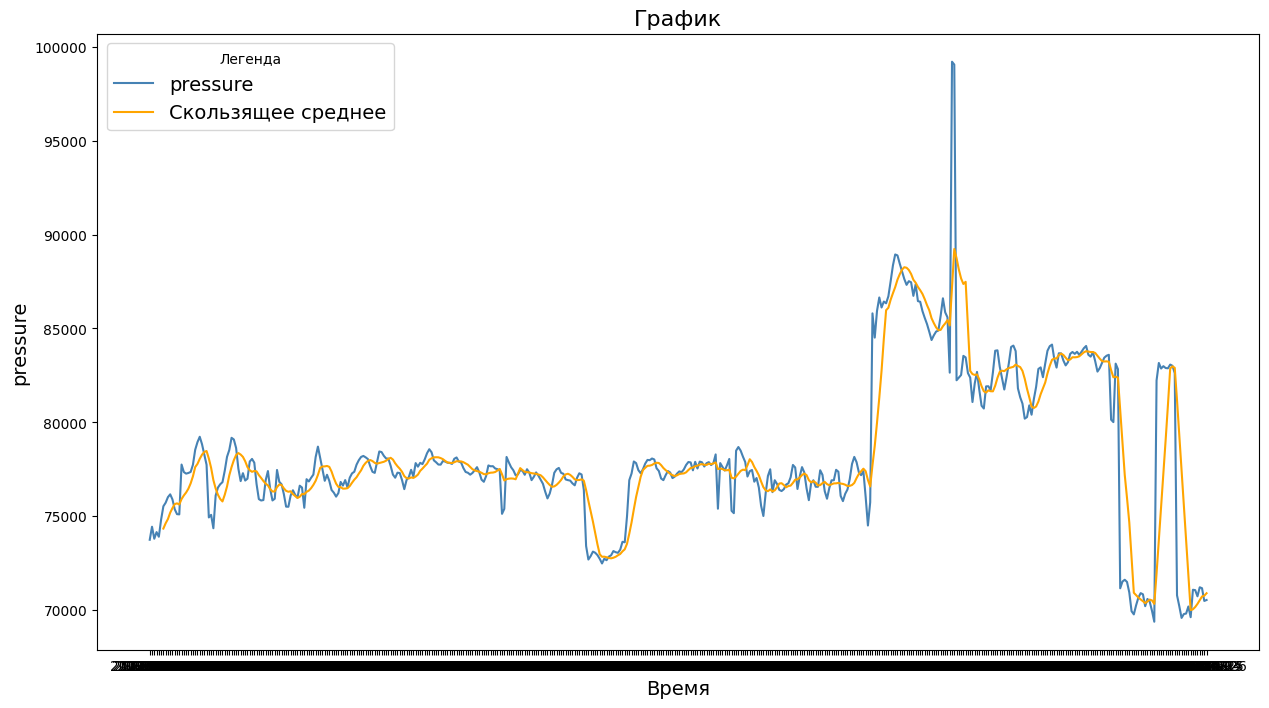

In [499]:
plt.figure(figsize = (15,8))

plt.plot(df1[param], label = param, color = 'steelblue')
plt.plot(df1[param].rolling(window = 7).mean(), label = 'Скользящее среднее', color = 'orange')
 
# легенда, ее положение на графике и размер шрифта
plt.legend(title = 'Легенда', loc = 'upper left', fontsize = 14)
 
plt.xlabel('Время', fontsize = 14)
plt.ylabel(param, fontsize = 14)
plt.title('График', fontsize = 16)
 
plt.show()

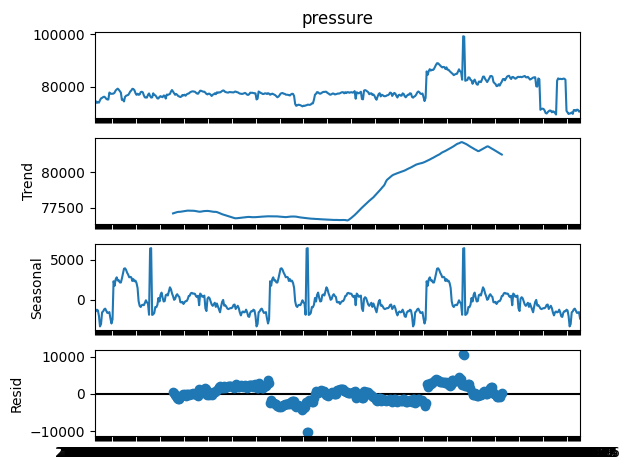

In [500]:
seasonal_decompose(df1[param], model = 'additive', period = 150).plot()
plt.show()

In [501]:
def check_stationarity(timeseries):
    # Perform the Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    p_value = result[1]
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {p_value}')
    return 'Stationary' if p_value < 0.05 else 'Non-Stationary'
temp = 0
if check_stationarity(df1[param]) == 'Non-Stationary':
    print('Non-Stationary')
    # Преобразование для удаления тренда
    temp = df1[param].rolling(window=7).mean()
    df1[param] = df1[param] - df1[param].rolling(window=7).mean()
          
    df1.dropna(inplace=True)

    # Построим графики
    plt.plot(df1[param], label='Стационарные')
    plt.legend()
    plt.title(param)
    plt.xlabel(param)
    plt.ylabel('Дата')
    plt.show()
else:
    print('Stationary')

ADF Statistic: -3.2518186224166943
p-value: 0.0171744374290211
Stationary


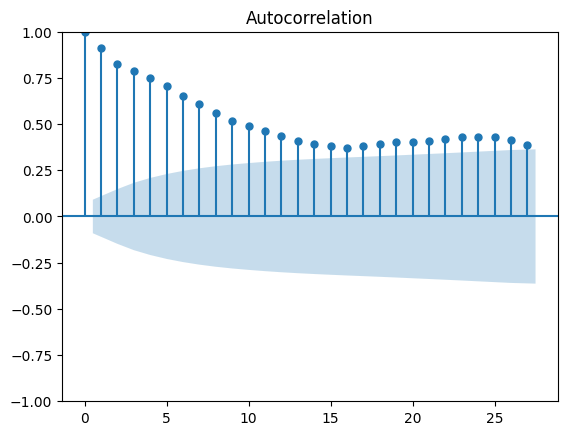

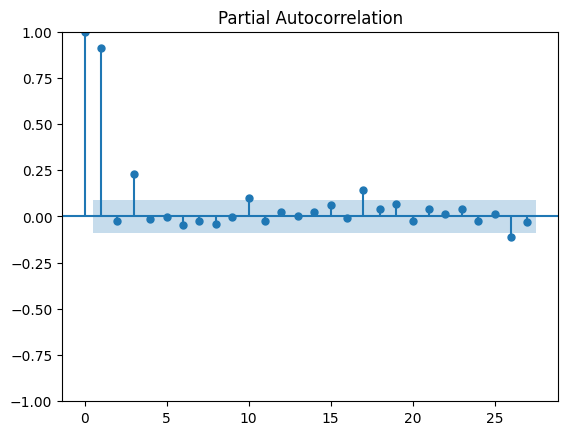

In [502]:
plot_acf(df1[param])
plot_pacf(df1[param])
plt.show()

In [503]:

p, d, q = 2, 1, 1
P, D, Q, s = 0, 1, 0, 7  # Assuming monthly seasonality
 
df1[param] = pd.to_numeric(df1[param], errors='coerce')
# Fit SARIMAX model
model = SARIMAX(df1[param], order=(p, d, q), seasonal_order=(P, D, Q, s))
results = model.fit()
model

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.04770D+00    |proj g|=  2.34316D-01

At iterate    5    f=  9.03225D+00    |proj g|=  5.90292D-03

At iterate   10    f=  9.03213D+00    |proj g|=  3.46188D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     29      1     0     0   2.551D-05   9.032D+00
  F =   9.0321264886997596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


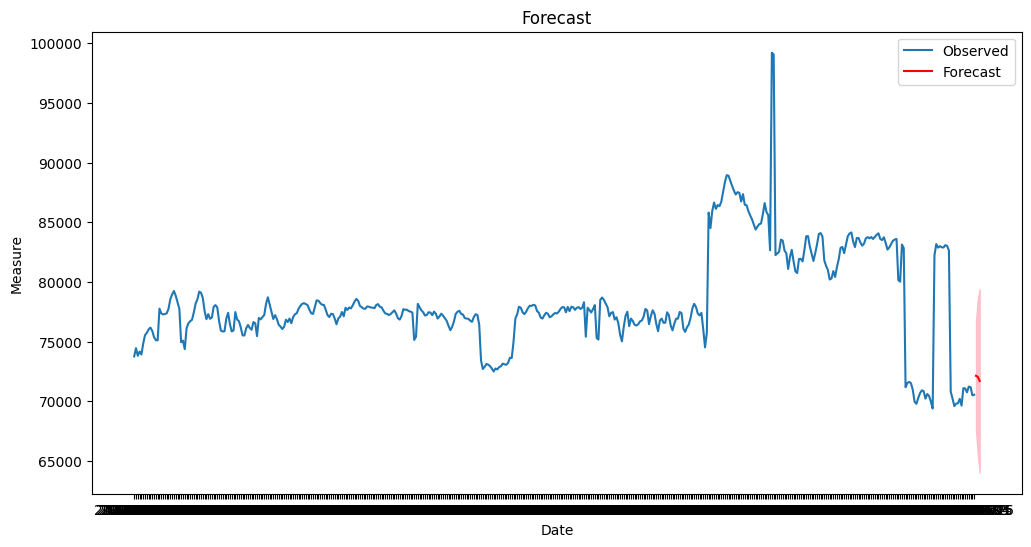

In [507]:
forecast_periods = 3 # Forecast the next 3 days
forecast = results.get_forecast(steps=forecast_periods)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()
 
# Plot the forecast
plt.figure(figsize=(12, 6))
plt.plot(df1[param], label='Observed')
plt.plot(forecast_mean, label='Forecast', color='red')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink')
plt.title("Forecast")
plt.xlabel("Date")
plt.ylabel("Measure")
plt.legend()
plt.show()

In [460]:
observed = df1[param][-forecast_periods:]
mae = mean_absolute_error(observed, forecast_mean)
mse = mean_squared_error(observed, forecast_mean)
print(f'MAE: {mae}')
print(f'MSE: {mse}')

MAE: 14.71571487526297
MSE: 238.78132464901387


In [508]:
if isinstance(temp, pd.Series):
    forecast_mean += temp[-3:].mean()
print(forecast_mean)

466    72128.217575
467    72045.330988
468    71699.248659
Name: predicted_mean, dtype: float64


In [438]:
# import json
# json_dict = dict()

In [462]:
# json_dict[param] = [min_max_mean[param], forecast_mean.to_list()]
# json_dict

{'pressure': [[99170.3, 100249.1, 99765.2],
  [101360.10458805696, 101242.88897415338, 100799.73301105273]],
 'temperature': [[15.0, 23.2, 18.2],
  [21.859324801502204, 23.362430571521955, 22.723389964094928]],
 'humidity': [[61.9, 80.9, 71.9],
  [54.048647005753466, 57.56694671947801, 74.25462238238329]]}

In [463]:
# Нормализуем min_max_scale  
# normalized_values = list()
# for param in measure_param:
#         normalized_values.append([(x - json_dict[param][0][0]) / (json_dict[param][0][1] - json_dict[param][0][0]) for x in json_dict[param][1]])

In [464]:
# используем формулу 0.7temp+0.1*pressure+0.2*humidity
# output_normalized_values= []
# for i in range(3):
#     output_normalized_values.append(0.7*normalized_values[1][i]+0.1*normalized_values[0][i]+0.2**normalized_values[2][i])


In [483]:
# output_normalized_values
# output_val = list()
# for el in output_normalized_values:
#     if 0.3 < el < 1:
#         output_val.append(0)
#     elif 1.0 <= el <= 4:
#         output_val.append(1)
#     else:
#         output_val.append(-1)
# output_val 

In [484]:
# output = dict()
# for i in range(3):
#     output[f'day{i+1}'] = output_val[i]
# #     output[f'day{i+1}'] = {'pressure':json_dict['pressure'][1][i], 'temperature':json_dict['temperature'][1][i],  'humidity':json_dict['humidity'][1][i]}

In [485]:
# output_path = '/kaggle/working/output_9.json'
# with open(output_path, mode='w', encoding='utf-8') as file:
#     json.dump(output, file)